In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data= pd.read_csv("./亚类分析/PbBa_weathering_chemical.csv")#铅钡风化的亚类分析

In [3]:
from sklearn.decomposition import PCA #使用PCA进行降维
X = data.iloc[:,1:15]
pca = PCA(n_components=2, copy=True,)
newX = pca.fit_transform(X)
#invX = pca.inverse_transform(newX)
#print(pca.components_)
print(pca.explained_variance_ratio_)
data['fac1'] = newX[:,0] #两个因子分别命名和储存到data中
data['fac2'] = newX[:,1]

[0.49568224 0.37582918]


成分数据维数庞大,考虑进行降维.用PCA将成分数据映射到二维的主成分之上
降维后两个维度的数据贡献了大于85%的方差,就认为该降维有代表性
利用二维的主成分进行聚类分析更加具有操作性,且易于可视化.
但是主成分与原化学成分之间并不具有很好的可解释性,
所以在主成分分析之后进行的kmeans,是用主成分为玻璃样本打上分类标签,并以该标签作为原数据集上文物样本的亚类标签.
随后再利用决策树做出成分与亚类标签之间的关系

In [4]:
from sklearn.cluster import KMeans #KMeans

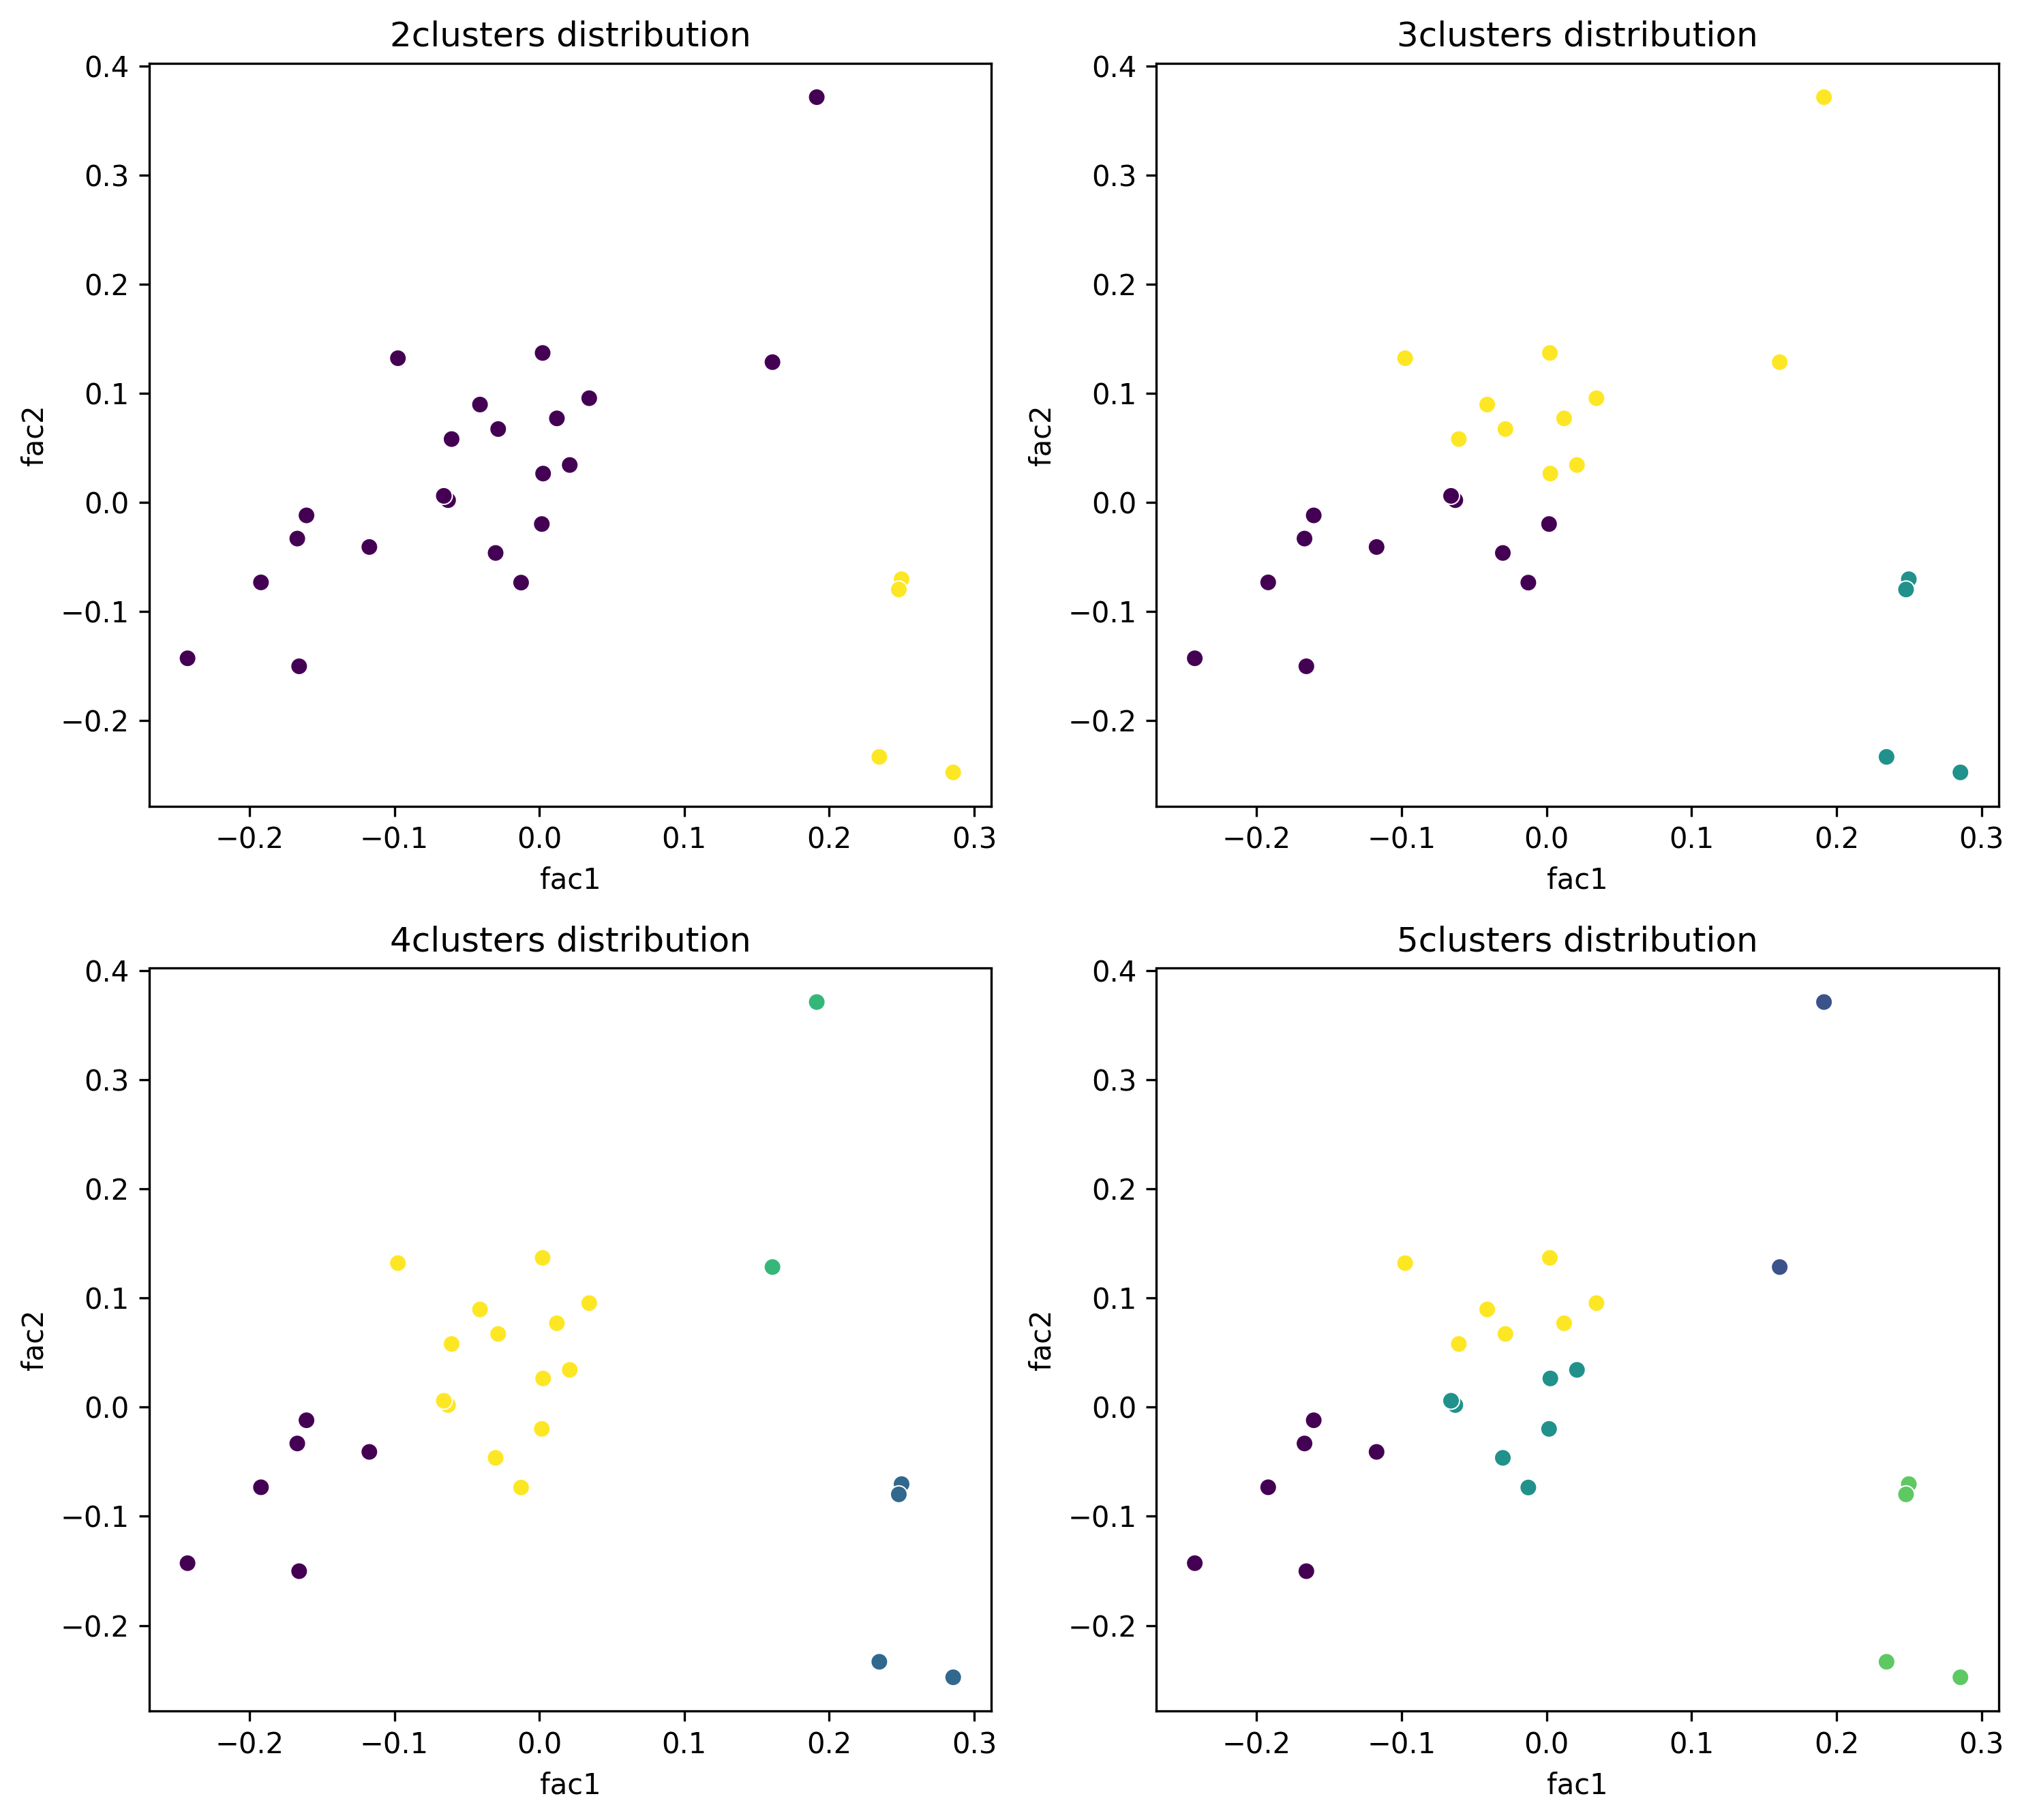

In [5]:
fig, sub = plt.subplots(2,2,dpi = 300, figsize = (10,9))#将无监督聚类的散点进行可视化
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for n, ax  in zip([2,3,4,5], sub.flatten()):
    kmean = KMeans(n_clusters=n)
    data.loc[:,str(n) + 'type'] = kmean.fit_predict(data.loc[:,['fac1','fac2']])
    sns.scatterplot(data = data, x = 'fac1', y = 'fac2', c =data.loc[:,str(n) + 'type'], ax =ax )
    ax.set_title(str(n)+'clusters distribution')
    plt.tight_layout()
    plt.savefig('铅钡风化聚类结果展示.png', dpi = 300, facecolor = 'w', bbox_inches = 'tight')

In [6]:
import numpy as np
from sklearn.model_selection import GridSearchCV # 通过网格方式来搜索参数
from sklearn.tree import DecisionTreeClassifier as dtc
import matplotlib.pyplot as plt # 可视化
from matplotlib import rcParams # 图大小
from sklearn.tree import plot_tree # 树图
#引入决策树进行亚类划分标准的确定

In [7]:
features = data.columns[1:15]
X = data[features]#设置待估Xy
for i in range(2,6):#从二分类到5分类,对不同的y利用决策树进行网格搜索,寻找最优分类数量
    y = data.loc[:,str(i)+'type']
    # 设置需要搜索的参数值，在这里寻找最优的决策树深度
    parameters = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
    model = dtc()  
    clf = GridSearchCV(model, parameters, cv=5) #网格搜索  
    clf.fit(X, y)
    # 输出最好的参数以及对应的准确率
    #print ("在",i,"个聚类中","最优分数: %.4f"%clf.best_score_, "  最佳参数: ",clf.best_params_,)
    if(i == 2):#存储最好的各类参数
        current_best = clf.best_score_
        best_number = i
        depth = clf.best_params_['max_depth']
    else:
        if(current_best < clf.best_score_):
            best_number = i
            current_best = clf.best_score_
            depth = clf.best_params_['max_depth']
print("在",best_number,"个聚簇时决策树交叉验证准确率最高,为",current_best,"决策树最大深度",depth)
#深度为1的决策树无法画图.且希望多展示一层.
depth = depth + 1


c:\Users\Nucleon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Nucleon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Nucleon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Nucleon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


在 2 个聚簇时决策树交叉验证准确率最高,为 1.0 决策树最大深度 1


In [8]:
classify_result = data[data.columns[0:15]]#输出最优分类结果
classify_result['sub_class'] = data[str(best_number)+'type']
classify_result.to_csv('铅钡风化亚类分类结果.csv')

C:\Users\Nucleon\AppData\Local\Temp\ipykernel_54192\1070219368.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classify_result['sub_class'] = data[str(best_number)+'type']


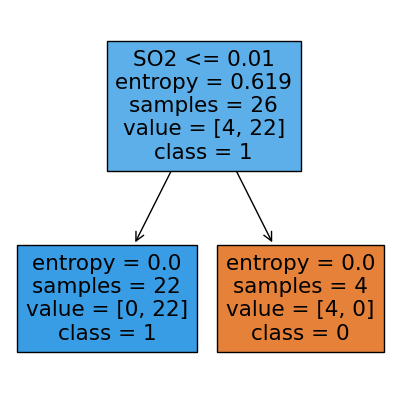

In [9]:
#多次执行以上语句之后,选择最优分数对应的聚类数量(如相同分数取聚类数少的:奥卡姆剃刀)和最优决策树层数+1作为铅钡风化玻璃划分子类数量
y = data.loc[:,str(best_number)+'type']#利用上面的最优参数取对应的列作为y
class_names = []
for i in range(0,best_number):
    class_names.append(str(i))#为可视化创建类标签
model = dtc(max_depth=depth,criterion = 'entropy')
model = model.fit(X, y)
rcParams['figure.figsize'] = (5, 5)
from sklearn.tree import plot_tree # 树图
plot_tree(
    model, 
    feature_names = features,
    class_names = class_names,  
    filled=True,
)
plt.savefig('铅钡风化玻璃中的亚类划分.png')

In [10]:
data= pd.read_csv("./亚类分析/PbBa_NOweathering_chemical.csv")#铅钡无风化的亚类分析

In [11]:
X = data.iloc[:,1:15]
pca = PCA(n_components=2, copy=True,)
newX = pca.fit_transform(X)
#invX = pca.inverse_transform(newX)
#print(pca.components_)
print(pca.explained_variance_ratio_)
data['fac1'] = newX[:,0] #两个因子分别命名和储存到data中
data['fac2'] = newX[:,1]

[0.68982661 0.19957483]


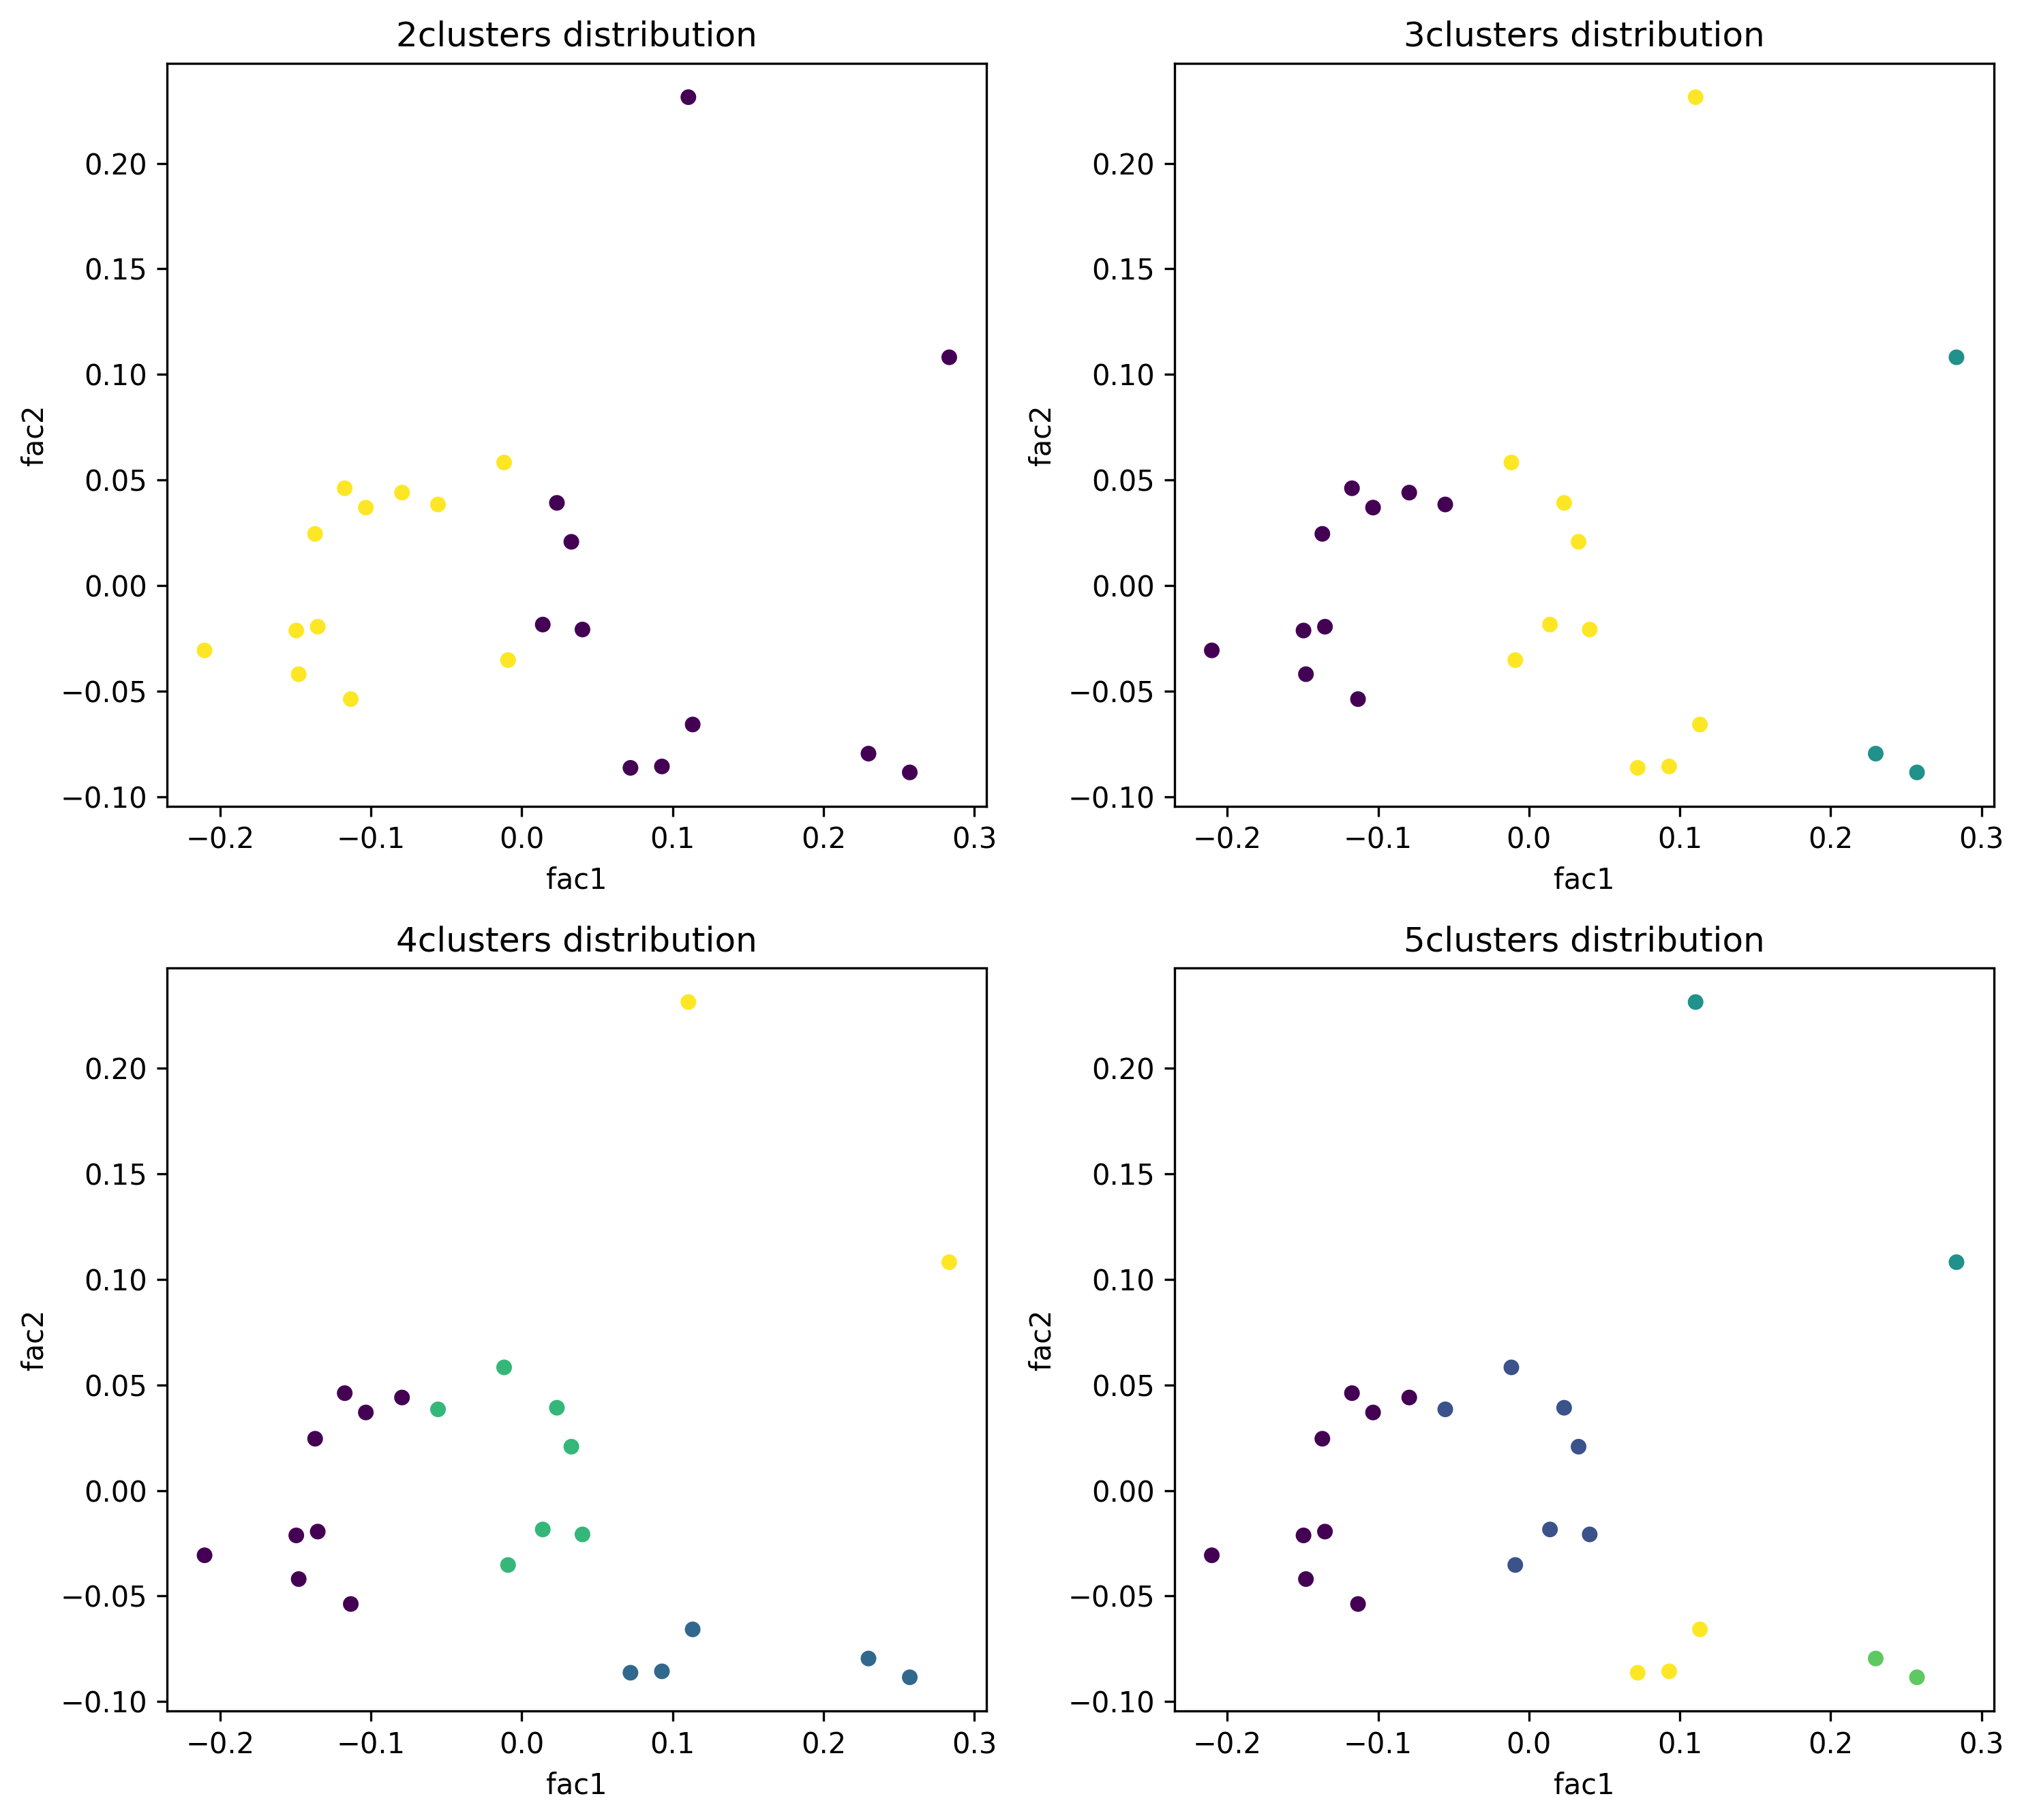

In [12]:
fig, sub = plt.subplots(2,2,dpi = 300, figsize = (10,9))#将无监督聚类的散点进行可视化
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for n, ax  in zip([2,3,4,5], sub.flatten()):
    kmean = KMeans(n_clusters=n)
    data.loc[:,str(n) + 'type'] = kmean.fit_predict(data.loc[:,['fac1','fac2']])
    sns.scatterplot(data = data, x = 'fac1', y = 'fac2', c =data.loc[:,str(n) + 'type'], ax =ax )
    ax.set_title(str(n)+'clusters distribution')
    plt.tight_layout()
    plt.savefig('铅钡无风化聚类结果展示.png', dpi = 300, facecolor = 'w', bbox_inches = 'tight')

In [13]:
features = data.columns[1:15]
X = data[features]#设置待估Xy
for i in range(2,6):#从二分类到5分类,对不同的y利用决策树进行网格搜索,寻找最优分类数量
    y = data.loc[:,str(i)+'type']
    # 设置需要搜索的参数值，在这里寻找最优的决策树深度
    parameters = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
    model = dtc()  
    clf = GridSearchCV(model, parameters, cv=5) #网格搜索  
    clf.fit(X, y)
    # 输出最好的参数以及对应的准确率
    #print ("在",i,"个聚类中","最优分数: %.4f"%clf.best_score_, "  最佳参数: ",clf.best_params_,)
    if(i == 2):#存储最好的各类参数
        current_best = clf.best_score_
        best_number = i
        depth = clf.best_params_['max_depth']
    else:
        if(current_best < clf.best_score_):
            best_number = i
            current_best = clf.best_score_
            depth = clf.best_params_['max_depth']
print("在",best_number,"个聚簇时决策树交叉验证准确率最高,为",current_best,"决策树最大深度",depth)
#深度为1的决策树无法画图.且希望多展示一层以看出最后一层分类情况
depth = depth + 1


c:\Users\Nucleon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Nucleon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


在 3 个聚簇时决策树交叉验证准确率最高,为 1.0 决策树最大深度 7


c:\Users\Nucleon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [14]:
classify_result = data[data.columns[0:15]]#输出最优分类结果
classify_result['sub_class'] = data[str(best_number)+'type']
classify_result.to_csv('铅钡无风化亚类分类结果.csv')

C:\Users\Nucleon\AppData\Local\Temp\ipykernel_54192\4097968316.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classify_result['sub_class'] = data[str(best_number)+'type']


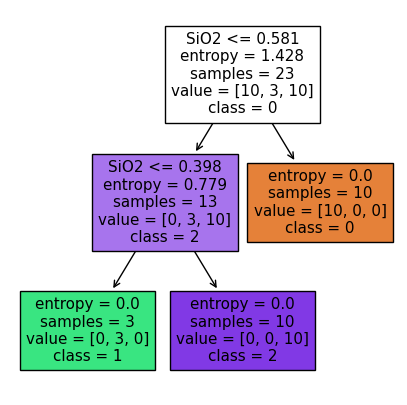

In [15]:
y = data.loc[:,str(best_number)+'type']#利用上面的最优参数取对应的列作为y
class_names = []
for i in range(0,best_number):
    class_names.append(str(i))#为可视化创建类标签
model = dtc(max_depth=depth,criterion = 'entropy')
model = model.fit(X, y)
rcParams['figure.figsize'] = (5, 5)
from sklearn.tree import plot_tree # 树图
plot_tree(
    model, 
    feature_names = features,
    class_names = class_names,  
    filled=True,
)
plt.savefig('铅钡无风化玻璃中的亚类划分.png')

In [16]:
data= pd.read_csv("./亚类分析/richK_weathering_chemical.csv")#高钾风化的亚类分析

In [17]:
X = data.iloc[:,1:15]
pca = PCA(n_components=2, copy=True,)
newX = pca.fit_transform(X)
#invX = pca.inverse_transform(newX)
#print(pca.components_)
print(pca.explained_variance_ratio_)
data['fac1'] = newX[:,0] #两个因子分别命名和储存到data中
data['fac2'] = newX[:,1]

[0.7586716  0.21391141]


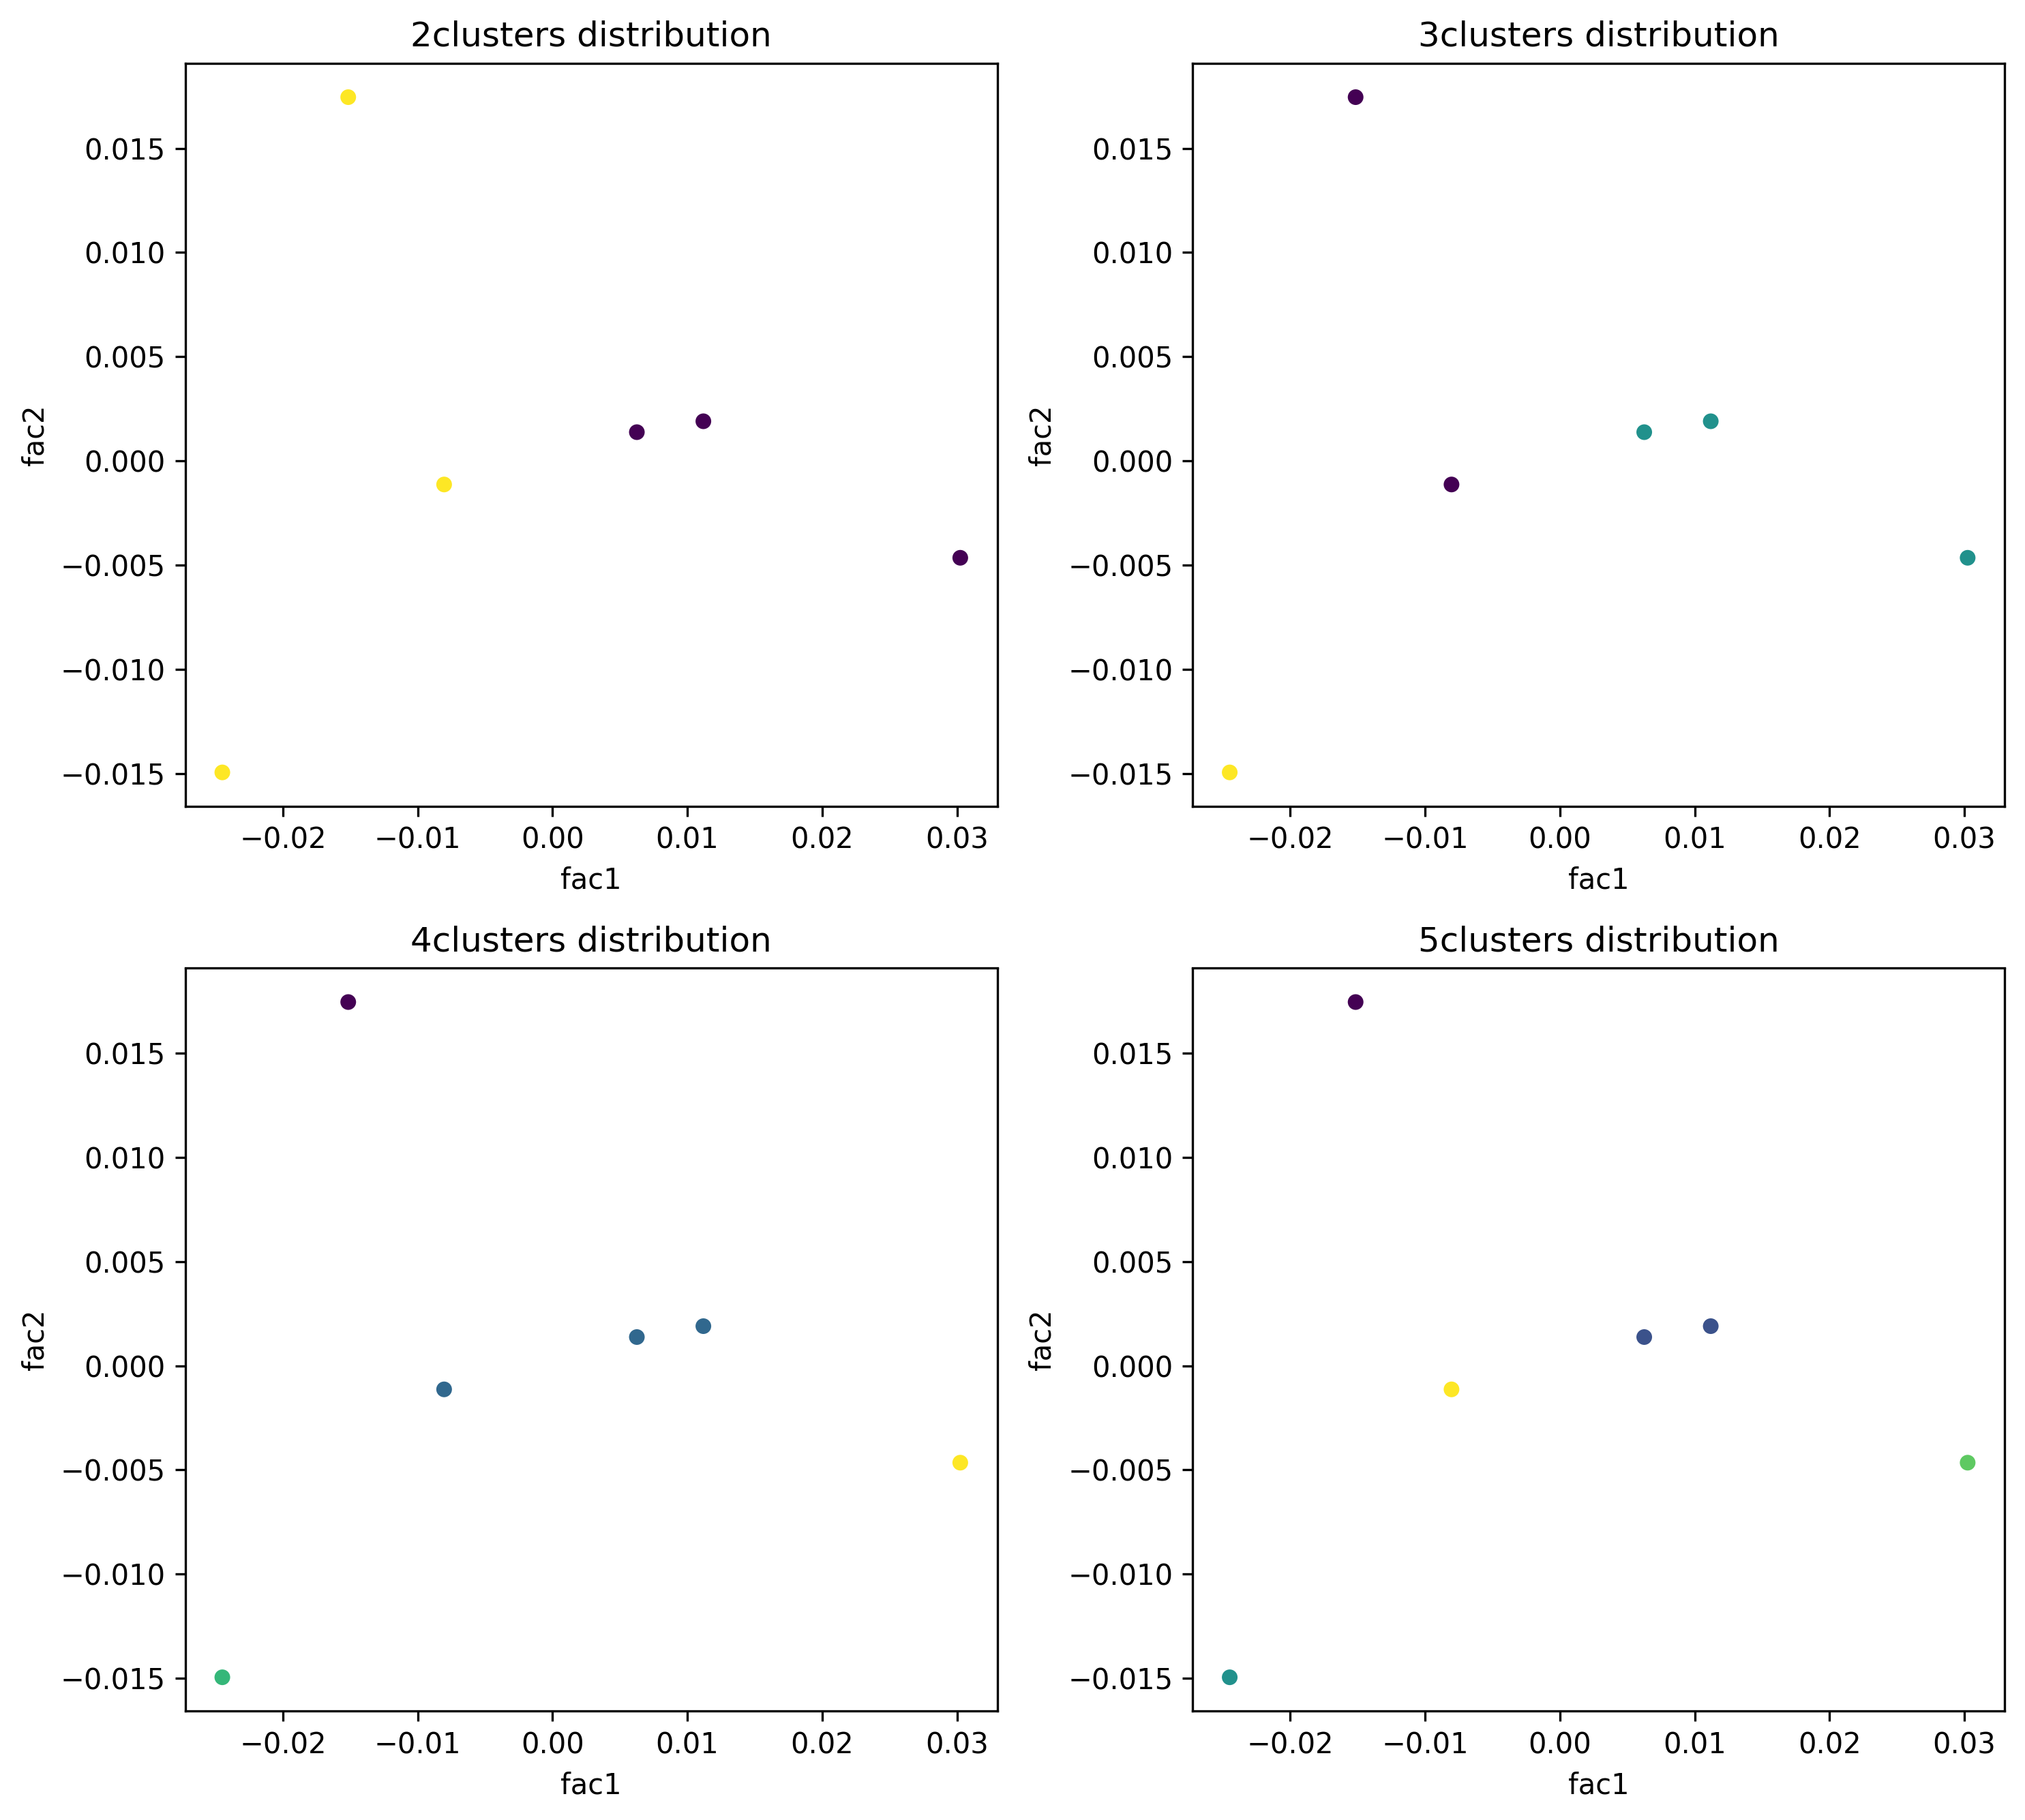

In [18]:
fig, sub = plt.subplots(2,2,dpi = 300, figsize = (10,9))#将无监督聚类的散点进行可视化
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for n, ax  in zip([2,3,4,5], sub.flatten()):
    kmean = KMeans(n_clusters=n)
    data.loc[:,str(n) + 'type'] = kmean.fit_predict(data.loc[:,['fac1','fac2']])
    sns.scatterplot(data = data, x = 'fac1', y = 'fac2', c =data.loc[:,str(n) + 'type'], ax =ax )
    ax.set_title(str(n)+'clusters distribution')
    plt.tight_layout()
    plt.savefig('高钾风化聚类结果展示.png', dpi = 300, facecolor = 'w', bbox_inches = 'tight')

In [19]:
features = data.columns[1:15]
X = data[features]#设置待估Xy
for i in range(2,6):#从二分类到5分类,对不同的y利用决策树进行网格搜索,寻找最优分类数量
    y = data.loc[:,str(i)+'type']
    # 设置需要搜索的参数值，在这里寻找最优的决策树深度
    parameters = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
    model = dtc()  
    clf = GridSearchCV(model, parameters, cv=2) #在第三类的实话网格搜索所需要的样本量不足.只能自身作为自身的测试集  
    clf.fit(X, y)
    # 输出最好的参数以及对应的准确率
    #print ("在",i,"个聚类中","最优分数: %.4f"%clf.best_score_, "  最佳参数: ",clf.best_params_,)
    if(i == 2):#存储最好的各类参数
        current_best = clf.best_score_
        best_number = i
        depth = clf.best_params_['max_depth']
    else:
        if(current_best < clf.best_score_):
            best_number = i
            current_best = clf.best_score_
            depth = clf.best_params_['max_depth']
print("在",best_number,"个聚簇时决策树交叉验证准确率最高,为",current_best,"决策树最大深度",depth)
#深度为1的决策树无法画图.且希望多展示一层以看出最后一层分类情况
depth = depth + 1

c:\Users\Nucleon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
c:\Users\Nucleon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
c:\Users\Nucleon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


在 2 个聚簇时决策树交叉验证准确率最高,为 1.0 决策树最大深度 6


In [20]:
classify_result = data[data.columns[0:15]]#输出最优分类结果
classify_result['sub_class'] = data[str(best_number)+'type']
classify_result.to_csv('高钾风化亚类分类结果.csv')

C:\Users\Nucleon\AppData\Local\Temp\ipykernel_54192\774960063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classify_result['sub_class'] = data[str(best_number)+'type']


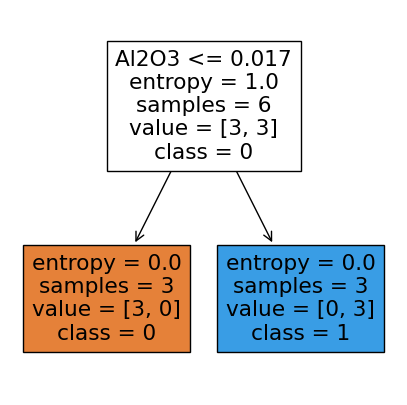

In [21]:
y = data.loc[:,str(best_number)+'type']#利用上面的最优参数取对应的列作为y
class_names = []
for i in range(0,best_number):
    class_names.append(str(i))#为可视化创建类标签
model = dtc(max_depth=depth,criterion = 'entropy')
model = model.fit(X, y)
rcParams['figure.figsize'] = (5, 5)
from sklearn.tree import plot_tree # 树图
plot_tree(
    model, 
    feature_names = features,
    class_names = class_names,  
    filled=True,
)
plt.savefig('高钾风化玻璃中的亚类划分.png')

In [22]:
data= pd.read_csv("./亚类分析/richK_NOweathering_chemical.csv")#高钾无风化的亚类分析

In [23]:
X = data.iloc[:,1:15]
pca = PCA(n_components=2, copy=True,)
newX = pca.fit_transform(X)
#invX = pca.inverse_transform(newX)
#print(pca.components_)
print(pca.explained_variance_ratio_)
data['fac1'] = newX[:,0] #两个因子分别命名和储存到data中
data['fac2'] = newX[:,1]

[0.75901117 0.12792656]


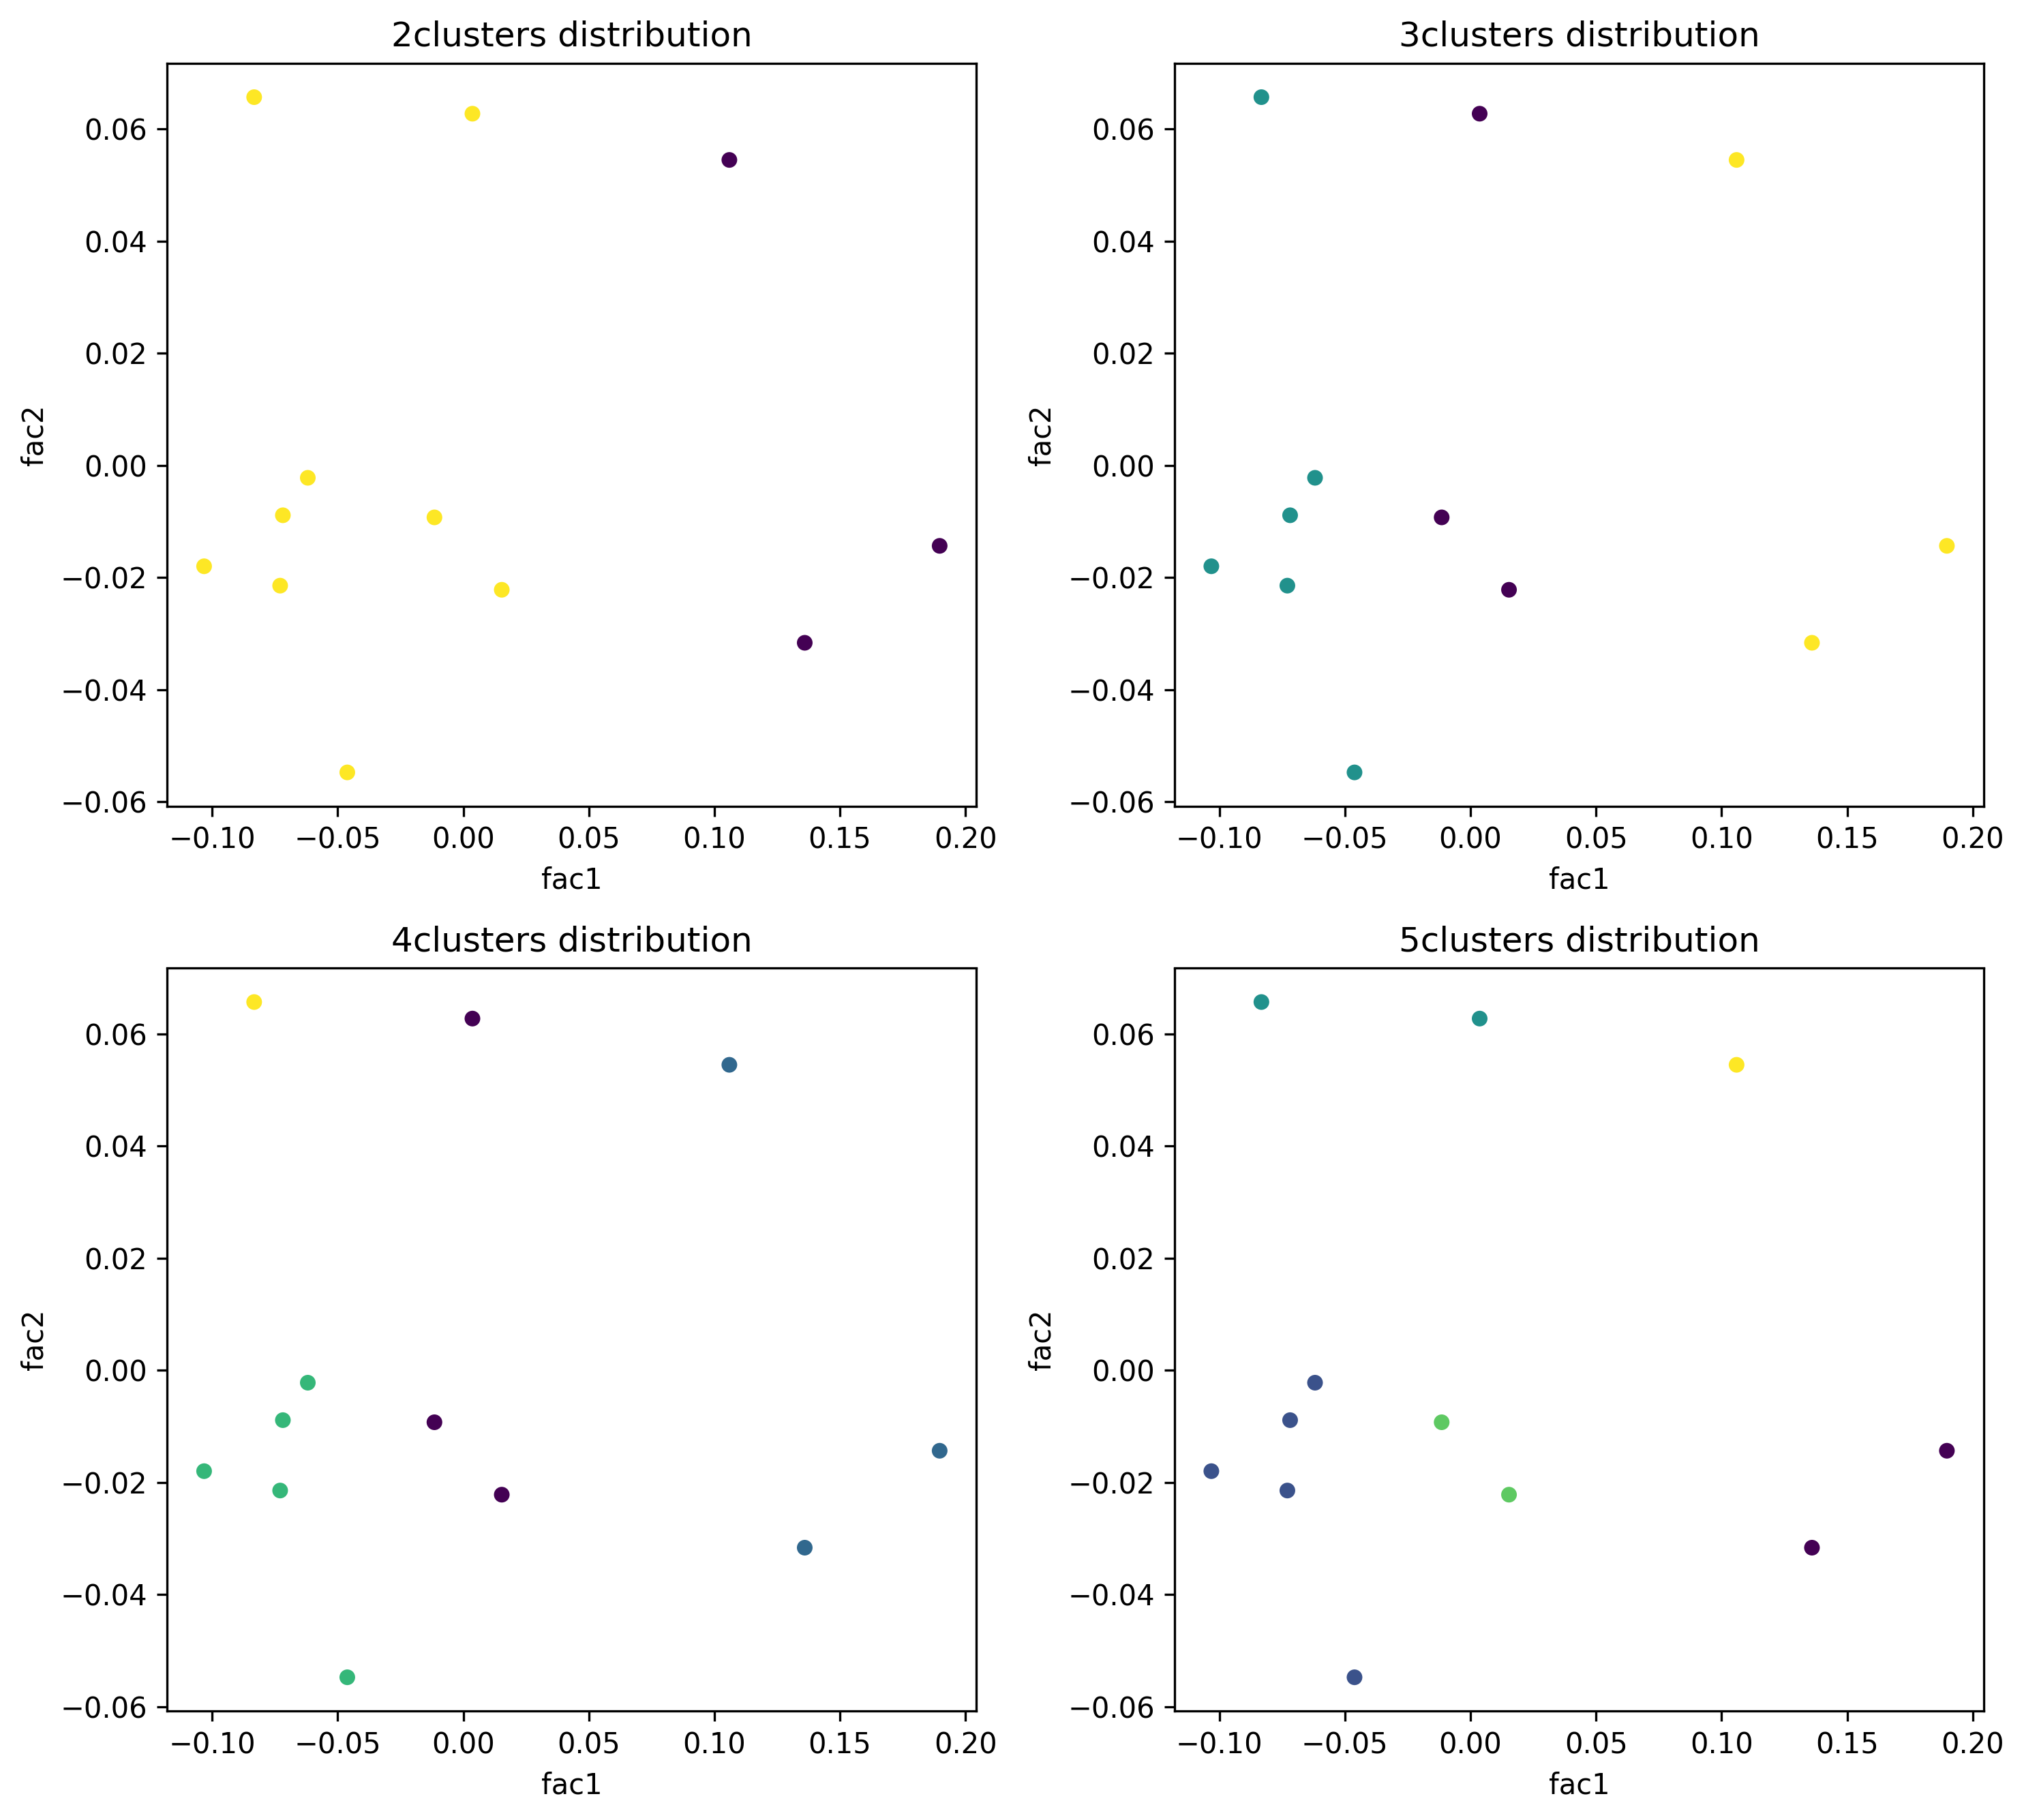

In [24]:
fig, sub = plt.subplots(2,2,dpi = 300, figsize = (10,9))#将无监督聚类的散点进行可视化
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for n, ax  in zip([2,3,4,5], sub.flatten()):
    kmean = KMeans(n_clusters=n)
    data.loc[:,str(n) + 'type'] = kmean.fit_predict(data.loc[:,['fac1','fac2']])
    sns.scatterplot(data = data, x = 'fac1', y = 'fac2', c =data.loc[:,str(n) + 'type'], ax =ax )
    ax.set_title(str(n)+'clusters distribution')
    plt.tight_layout()
    plt.savefig('高钾无风化聚类结果展示.png', dpi = 300, facecolor = 'w', bbox_inches = 'tight')

In [25]:
features = data.columns[1:15]
X = data[features]#设置待估Xy
for i in range(2,6):#从二分类到5分类,对不同的y利用决策树进行网格搜索,寻找最优分类数量
    y = data.loc[:,str(i)+'type']
    # 设置需要搜索的参数值，在这里寻找最优的决策树深度
    parameters = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
    model = dtc()  
    clf = GridSearchCV(model, parameters, cv=5) #网格搜索  
    clf.fit(X, y)
    # 输出最好的参数以及对应的准确率
    #print ("在",i,"个聚类中","最优分数: %.4f"%clf.best_score_, "  最佳参数: ",clf.best_params_,)
    if(i == 2):#存储最好的各类参数
        current_best = clf.best_score_
        best_number = i
        depth = clf.best_params_['max_depth']
    else:
        if(current_best < clf.best_score_):
            best_number = i
            current_best = clf.best_score_
            depth = clf.best_params_['max_depth']
print("在",best_number,"个聚簇时决策树交叉验证准确率最高,为",current_best,"决策树最大深度",depth)
#深度为1的决策树无法画图.且希望多展示一层以看出最后一层分类情况
depth = depth + 1

c:\Users\Nucleon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Nucleon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Nucleon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Nucleon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


在 2 个聚簇时决策树交叉验证准确率最高,为 1.0 决策树最大深度 7


In [26]:
classify_result = data[data.columns[0:15]]#输出最优分类结果
classify_result['sub_class'] = data[str(best_number)+'type']
classify_result.to_csv('高钾无风化亚类分类结果.csv')

C:\Users\Nucleon\AppData\Local\Temp\ipykernel_54192\2344450142.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classify_result['sub_class'] = data[str(best_number)+'type']


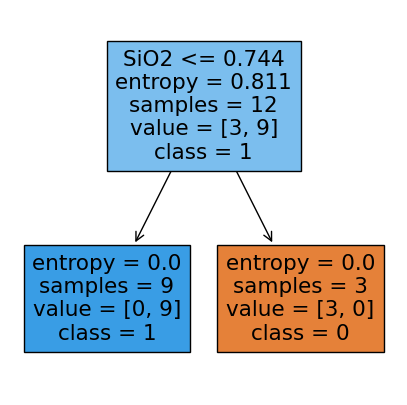

In [27]:
y = data.loc[:,str(best_number)+'type']#利用上面的最优参数取对应的列作为y
class_names = []
for i in range(0,best_number):
    class_names.append(str(i))#为可视化创建类标签
model = dtc(max_depth=depth,criterion = 'entropy')
model = model.fit(X, y)
rcParams['figure.figsize'] = (5, 5)
from sklearn.tree import plot_tree # 树图
plot_tree(
    model, 
    feature_names = features,
    class_names = class_names,  
    filled=True,
)
plt.savefig('高钾无风化玻璃中的亚类划分.png')